# DAG Example

In [1]:
import numpy as np
import networkx as nx
import math
import time
import datetime
import os
import pickle as pkl
import seaborn as sns

import sys
sys.path.insert(0, '../')
import utils
from ahk import AHK_graphon

from matplotlib import pyplot as plt

from tqdm.auto import tqdm


Random ER DAGs with min 3 and max 7 nodes 
Edge density: 0.4305799648506151
Loaded  100  training graphs 

Samples:


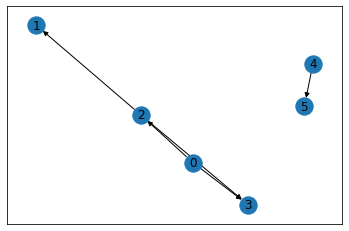

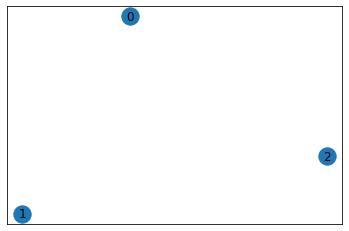

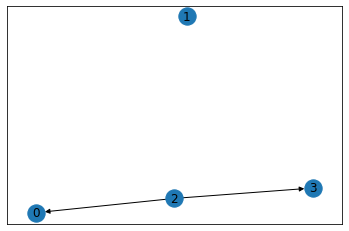

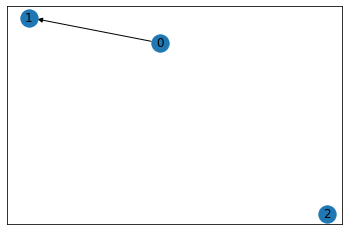

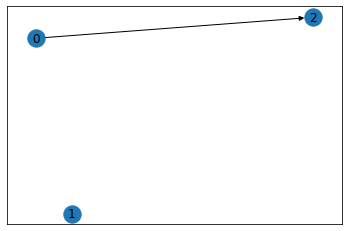

In [2]:
# Load training data and display some examples:
traindata_dump=pkl.load(open("../dataset/DAG/traindags.pkl","rb"))
traindata_nx=traindata_dump['data']

print(traindata_dump['readme'])
print("Loaded ", len(traindata_nx), " training graphs \n")

print("Samples:")

idxs=np.random.randint(len(traindata_nx), size=5)
for idx in idxs:
    nx.draw_networkx(traindata_nx[idx])
    plt.show()

# transform networkx graphs into world objects:
traindata=utils.batch_nx_to_world(traindata_nx)

# Learn a model

In [ ]:
# Learning settings:

# Initialize model
binbounds=utils.uni_bins(1)
learnmodel=AHK_graphon(traindata[0].sig,binbounds)

settings={}

settings['num_pi_b']=50
settings['batchsize']=5
settings['soft']=0.001
settings['numepochs']=50
settings['early_stop']=3 #Number of epochs with no log-likelihood improvement required for early stopping
settings['bingain']=0.01 #the factor by which a bin refinement has improved log-likelihood in order
                         #to continue bin refinements
settings['learn_bins']=False
settings['with_trace']=False
settings['randombatches']=False
settings['adaptbatchsize']=False
settings['ubias']=0.0
settings['savepath']='../Experiments/DAG/'

#Adam params:
settings['ad_alpha']=0.01
settings['ad_beta1']=0.9
settings['ad_beta2']=0.999
settings['ad_epsilon']=1e-8

settings['seed']=0
settings['method']="adam"

In [ ]:
# learn:
rng=np.random.default_rng(seed=settings['seed'])
learnmodel.rand_init(rng)
best,loglik,_=learnmodel.learn(settings,traindata,rng,exact_gradients=False,info_each_epoch=False)

# Inference

Use either learned model:

In [ ]:
model=best

Or load model from file:

In [4]:
modelfile="../Experiments/DAG/model_learned.pkl"
model=pkl.load(open(modelfile,"rb"))

### Small query graph

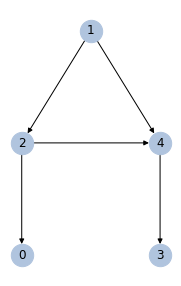

all missing edges are considered 'unknown' !


In [5]:
# Define small query graph:
w5 = utils.World(model.signature,5)
w5.binaries+= -1
w5.setatom(0,(4,3),1)
w5.setatom(0,(1,2),1)
w5.setatom(0,(1,4),1)
w5.setatom(0,(2,4),1)
w5.setatom(0,(2,0),1)

plt.figure(figsize=(3,5))
positions=([0,0],[0.5,2],[0,1],[1,0],[1,1])
nx.draw_networkx(w5.to_nx(),pos=positions,with_labels=True,node_size=500,node_color='lightsteelblue')

plt.axis("off")
plt.show()

print("all missing edges are considered 'unknown' !")

In [6]:
# Define the queries:
q1=[[(0,1,0,True)],[(0,0,3,True)],[(0,3,0,True)],[(0,0,3,True),(0,3,0,True)],[(0,1,0,True),(0,0,3,True)],[(0,3,2,True)]]

# Compute exact probabilities:
qp,p,_=model.compute_prob(w5,query=q1)

for i,q in enumerate(q1):
    print("probability of edges ")
    for at in q:
        print(at[1]," -> ",at[2], "  ")
    print(qp[i],"\n")


probability of edges 
1  ->  0   
0.4491981032591168 

probability of edges 
0  ->  3   
0.27254294272747115 

probability of edges 
3  ->  0   
0.16315612850461306 

probability of edges 
0  ->  3   
3  ->  0   
0.008853777262791808 

probability of edges 
1  ->  0   
0  ->  3   
0.13160586713193118 

probability of edges 
3  ->  2   
0.011733406234197274 



### Large query graph

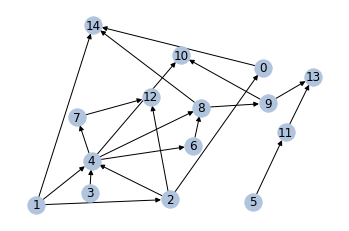

In [7]:
# Define the large query graph:
w15 = utils.World(model.signature,15)
w15.binaries+= -1 #making all edges unknown 
w15.setatom(0,(3,4),1)
w15.setatom(0,(1,2),1)
w15.setatom(0,(1,4),1)
w15.setatom(0,(2,4),1)
w15.setatom(0,(2,0),1)
w15.setatom(0,(4,7),1)
w15.setatom(0,(4,8),1)
w15.setatom(0,(8,9),1)
w15.setatom(0,(9,10),1)
w15.setatom(0,(4,10),1)
w15.setatom(0,(1,14),1)
w15.setatom(0,(11,13),1)
w15.setatom(0,(8,14),1)
w15.setatom(0,(9,13),1)
w15.setatom(0,(6,8),1)
w15.setatom(0,(5,11),1)
w15.setatom(0,(2,12),1)
w15.setatom(0,(7,12),1)
w15.setatom(0,(0,14),1)
w15.setatom(0,(4,6),1)

positions=np.array(([770,637],[520,310],[667,323],[579,339],[581,415],[759,318],\
           [693,451],[565,519],[702,542],[775,552],[680,666],[795,483],[646,567],[825,615],[583,738]))

plt.figure(figsize=(6,4))    
plt.axis("off")
nx.draw_networkx(w15.to_nx(),with_labels=True,pos=positions,node_color='lightsteelblue')
plt.show()

In [11]:
# Define the queries:
q2=[[(0,1,13,True)],[(0,13,1,True)],[(0,7,11,True)]]


# Approximate inference with different sample sizes
# Takes a while. For faster results, reduce maximal
# 'numsamples' and number of runs.
rng=np.random.default_rng()
numsamples=[100,500,1000,5000,20000]
#numsamples=[100,500,1000,5000]
runs=5

results=np.zeros((len(numsamples),runs,len(q2)))
times=np.zeros(len(numsamples))

for i,ns in enumerate(numsamples):
    tick=time.time()
    print("samples ",ns)
    for j in tqdm(range(runs)):
        p,_,_=model.importance_sample({},w15,rng,query=q2,numsamples=ns,sampler='nonseq')
        results[i,j,:]=p
    times[i]=time.time()-tick

samples  100


  0%|          | 0/5 [00:00<?, ?it/s]

samples  500


  0%|          | 0/5 [00:00<?, ?it/s]

samples  1000


  0%|          | 0/5 [00:00<?, ?it/s]

samples  5000


  0%|          | 0/5 [00:00<?, ?it/s]

samples  20000


  0%|          | 0/5 [00:00<?, ?it/s]

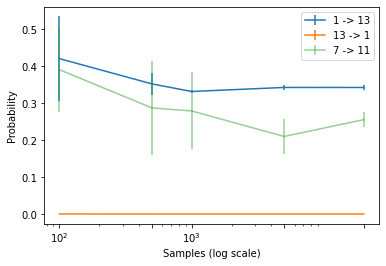

In [24]:
avgs=np.average(results,axis=1)
std=np.std(results,axis=1)

plt.errorbar(numsamples,avgs[:,0],yerr=std[:,0],label="1 -> 13")
plt.errorbar(numsamples,avgs[:,1],yerr=std[:,1],label="13 -> 1")
plt.errorbar(numsamples,avgs[:,2],yerr=std[:,2],label="7 -> 11",alpha=0.5)
plt.xscale('log')
plt.xticks(numsamples)
plt.xlabel("Samples (log scale)")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [23]:
avgs[-1,:]

array([0.34283869, 0.00110134, 0.25597619])

# Illustrating importance sampling

Computing the exact probabilities P(pi,b,w) for all pi,b for the small graph:

In [ ]:
_,p,PIU=model.compute_prob(w5,return_pibs=True)

Computing the probability P(w) by importance sampling, and returning the empirical sampling distribution over pi,b:

In [ ]:
numsamples=100000
pnew,_,SPIU=model.importance_sample({},w5,rng,return_pibs=True,\
                                     numsamples=numsamples,sampler="nonseq",verbose=False,with_trace=False)

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(PIU,ax=axes[0])
sns.heatmap(SPIU,ax=axes[1])
axes[0].set_xlabel("Bin assignment")
axes[0].set_ylabel("Permutation")
axes[0].set_title("Exact probabilities")
axes[1].set_xlabel("Bin assignment")
axes[1].set_ylabel("Permutation")
axes[1].set_title("Importance sampling distribution")
#axes[1].set_xlim((36,56))
plt.show()